# Skyrmion tube in a helical background

In [1]:
# %%
import sys
import plot_tools as pt
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib as mpl
import numpy as np
from skimage import measure

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
import scipy.interpolate as si
from matplotlib.colors import LightSource
import oommfpy.tools as ot

from pathlib import Path
import glob

In [2]:
import fidimag as fd
from fidimag.common import CuboidMesh
from fidimag.atomistic import Sim

# Define a Fidimag simulation

We define a Fidimag simulation with 30x30x30 spins to load the `npy` files of the NEBM simulations and visualise them:

In [20]:
FIELD = 100
nx, ny, nz = 30, 30, 30
dx, dy, dz = 1, 1, 1
mesh = CuboidMesh(nx=nx, ny=ny, nz=nz,
                  dx=dx, dy=dy, dz=dz,
                  x0=-nx * 0.5, y0=-ny * 0.5, z0=-nz * 0.5,
                  unit_length=1.,
                  periodicity=(True, True, False)
                  )
x, y, z = mesh.coordinates[:, 0], mesh.coordinates[:, 1], mesh.coordinates[:, 2]
xs, ys, zs = np.unique(x), np.unique(y), np.unique(z)

sim_name = 'sk_helix'
sim = Sim(mesh, name=sim_name, integrator='sundials_openmp')

sim.mu_s = 1
sim.add(fd.atomistic.Exchange(1))
sim.add(fd.atomistic.DMI(0.727, dmi_type='bulk'))
bz_min = FIELD
sim.add(fd.atomistic.Zeeman((0.0, 0.0, bz_min * 1e-3)), save_field=True)
kc = -0.05
if np.abs(kc) > 0.0:
    sim.add(fd.atomistic.CubicAnisotropy(kc))

Number of threads (CVODE) = 8


In [21]:
GNEBM_PATH = Path('sims/fidimag/gnebm/cubic_anisotropy/hx-sk-tube_to_hx_kc-5e-2/npys')

Load the spins directions in the `spins` list to add the images of the energy band. We will use the energy band from the simulation at Bz=100. The `78` step in the directory name might slightly differ if the simulation is run in a different machine, as this is the step where the simulation converged for the machine that originally ran the code:

In [23]:
spins = []

for i in range(29):
    sim.set_m(np.load(GNEBM_PATH / f'hx-sk-tube_to_hx_Bz000100mT_CI_78/image_0000{i:02d}.npy'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

Make a 3 images figure showing images 0, 8 and 15 of the energy band. We show the isosurfaces with `s_z = 0`, which we find using `scikit image`. The spin field will be interpolated using a `RegularGridInterpolator` in order to colour the triangles of the isosurfaces according to the spin's in-plane directions.

/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


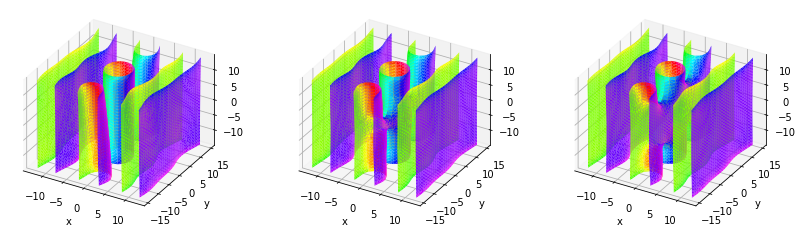

In [25]:
f = plt.figure(figsize=(14, 4))

for i, sp_idx in enumerate([0, 8, 15]):
    
    ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
    # ax.set_p

    vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz)
    verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                           spacing=(1, 1, 1))
    
    verts -= 14.5
    p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                        triangles=faces,
                        # cannot control color point-wise in trisurf:  
                        color='red',
                        # cmap='RdYlBu', 
                        lw=1, vmin=-1, vmax=1
                        )

    # Interpolate spin field
    vol_mx = spins[sp_idx][:, 0].reshape(nx, ny, nz).T
    data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
    vol_my = spins[sp_idx][:, 1].reshape(nx, ny, nz).T
    data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
    vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz).T
    data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)
    
    tri_centres = np.mean(verts[faces], axis=1)
    m_interp = np.column_stack((data_interp_x(tri_centres),
                                data_interp_y(tri_centres),
                                data_interp_z(tri_centres)))

    colors = ot.generate_colours(m_interp)
    p._facecolors2d = p._facecolors3d
    p.set_facecolors(colors)

    # ax.add_collection3d(col)

    # ax.set_xlim([x.min(), x.max()])
    # ax.set_ylim([y.min(), y.max()])
    # ax.set_zlim([z.min(), z.max()])
    ax.autoscale()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
plt.savefig('hx_sk_transition.pdf', bbox_inches='tight')

We can do the same but showing only a portion of the plot, with `x > 5`. We can do this by using a `numpy` array filter where the `x` coordinates of the simulation mesh is larger than 5.

In [60]:
# Create Numpy mask from the x array which has the x components
# of the spin positions
ftr = x < 5

In [61]:
f_spins = []

for i in range(29):
    sim.set_m(np.load(GNEBM_PATH / f'hx-sk-tube_to_hx_Bz000100mT_CI_78/image_0000{i:02d}.npy'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    sp_copy = sp_copy[ftr]
    f_spins.append(sp_copy)

In [62]:
f_x, f_y, f_z = x[ftr], y[ftr], z[ftr]
f_xs, f_ys, f_zs = np.unique(f_x), np.unique(f_y), np.unique(f_z)
f_nx, f_ny, f_nz = len(f_xs), len(f_ys), len(f_zs)

f_xyzs = (f_xs, f_ys, f_zs)
f_nxyzs = (f_nx, f_ny, f_nz) 

In [63]:
f_nxyzs

(20, 30, 30)

/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


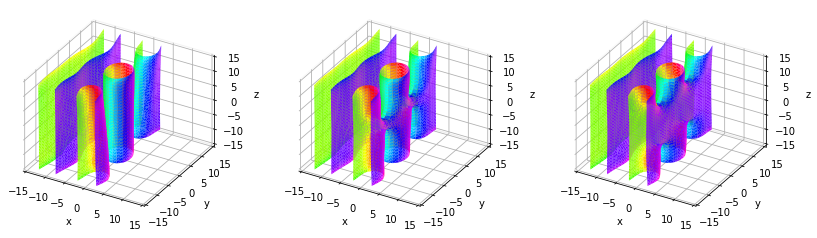

In [69]:
f = plt.figure(figsize=(14, 4))

for i, sp_idx in enumerate([0, 8, 15]):
    
    ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
    # ax.set_p

    f_vol_mz = f_spins[sp_idx][:, 2].reshape(f_nz, f_ny, f_nx)
    verts, faces, normals, values = measure.marching_cubes(f_vol_mz.T, 0., 
                                                           spacing=(1, 1, 1))
    
    verts -= 14.5
    p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                        triangles=faces,
                        # cannot control color point-wise in trisurf:  
                        color='red',
                        # cmap='RdYlBu', 
                        lw=1, vmin=-1, vmax=1
                        )
    # print(p._facecolors3d.shape)
    vol_mx = spins[sp_idx][:, 0].reshape(nx, ny, nz).T
    data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
    vol_my = spins[sp_idx][:, 1].reshape(nx, ny, nz).T
    data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
    vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz).T
    data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)
    
    tri_centres = np.mean(verts[faces], axis=1)
    # colors = mpl.cm.RdBu(data_interp(tri_centres))
    # print('tcs', tri_centres.shape)
    m_interp = np.column_stack((data_interp_x(tri_centres),
                                data_interp_y(tri_centres),
                                data_interp_z(tri_centres)))
    # print('ms', m_interp.shape)
    colors = ot.generate_colours(m_interp)
    p._facecolors2d = p._facecolors3d
    p.set_facecolors(colors)

    # ax.add_collection3d(col)

    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])
    # ax.autoscale()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

plt.savefig('hx_sk_transition_Bz100e-3.pdf', bbox_inches='tight')

# Energy barrier evolution

Here we show how the largest energy point along the energy bands evolve with the number of iterations of the GNEBM.

Text(0, 0.5, 'E')

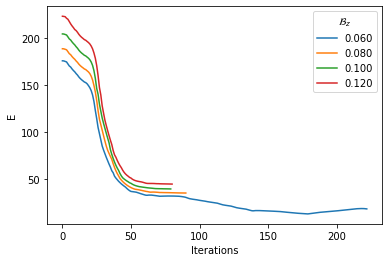

In [18]:
for i in range(60, 121, 20):
    data = np.loadtxt(f'sims/fidimag/gnebm/cubic_anisotropy/hx-sk-tube_to_hx_kc-5e-2/ndts/hx-sk-tube_to_hx_Bz{i:06d}mT_energy.ndt')
    plt.plot(np.max(data[:, 1:20], axis=1) - data[:, 1], label=f'{i * 1e-3:.3f}')

plt.legend(title='$\mathcal{B}_z$')
# plt.ylim(90, 120)
plt.xlabel('Iterations')
plt.ylabel('E')

In [25]:
data = np.loadtxt(f'sims/fidimag/gnebm/cubic_anisotropy/sk-tube_to_conical_kc-5e-2/ndts/sk-tube_to_conical_Bz340mT_energy.ndt')
data

array([[ 0.00000000e+00, -9.06654742e+04, -9.06631540e+04, ...,
        -9.06174752e+04, -9.06267137e+04, -9.06300000e+04],
       [ 1.00000000e+00, -9.06654742e+04, -9.06631774e+04, ...,
        -9.06175173e+04, -9.06267265e+04, -9.06300000e+04],
       [ 2.00000000e+00, -9.06654742e+04, -9.06632178e+04, ...,
        -9.06175902e+04, -9.06267485e+04, -9.06300000e+04],
       ...,
       [ 3.98000000e+02, -9.06654742e+04, -9.06652972e+04, ...,
        -9.06282293e+04, -9.06202731e+04, -9.06300000e+04],
       [ 3.99000000e+02, -9.06654742e+04, -9.06652979e+04, ...,
        -9.06279120e+04, -9.06201964e+04, -9.06300000e+04],
       [ 4.00000000e+02, -9.06654742e+04, -9.06652987e+04, ...,
        -9.06275089e+04, -9.06201712e+04, -9.06300000e+04]])

Text(0.5, 1.0, 'Sk tube to conical')

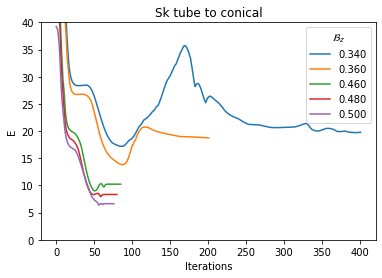

In [30]:
for i in range(340, 501, 20):
    try:
        data = np.loadtxt(f'sims/fidimag/gnebm/cubic_anisotropy/sk-tube_to_conical_kc-5e-2/ndts/sk-tube_to_conical_Bz{i}mT_energy.ndt')
        plt.plot(np.max(data[:, 1:10], axis=1) - data[:, 1], label=f'{i * 1e-3:.3f}')
    except:
        continue
plt.legend(title='$\mathcal{B}_z$')
plt.ylim(0, 40)
plt.xlabel('Iterations')
plt.ylabel('E')
plt.title('Sk tube to conical')

Text(0.5, 1.0, 'Sk tube to conical - No anisotropy')

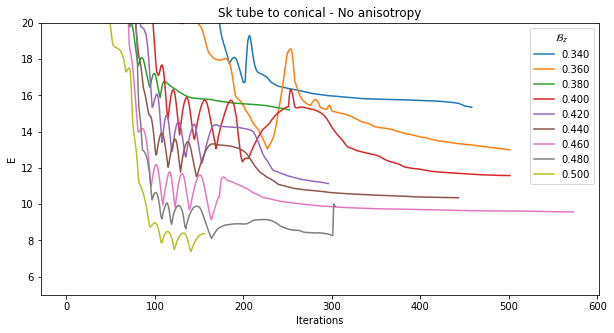

In [36]:
plt.figure(figsize=(10, 5))

for i in range(340, 501, 20):
    try:
        data = np.loadtxt(f'sims/fidimag/gnebm/D727e-3/ndts/sk-tube_to_one-dim-mod_Bz{i}mT_energy.ndt')
        plt.plot(np.max(data[:, 1:15], axis=1) - data[:, 1], label=f'{i * 1e-3:.3f}')
    except:
        continue
plt.legend(title='$\mathcal{B}_z$')
plt.ylim(5, 20)
plt.xlabel('Iterations')
plt.ylabel('E')
plt.title('Sk tube to conical - No anisotropy')